 # DANN for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F
from torch import nn
from torch.cuda.amp import GradScaler   
from torch import autocast

from src.da_models.autoencoder import AutoEncoder
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import load_spatial, load_sc, get_selected_dir
from src.utils.evaluation import format_iters


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_3788926/3346142498.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
DATA_DIR = "data"

TRAIN_USING_ALL_ST_SAMPLES = False
N_MARKERS = 20
ALL_GENES = True
N_SPOTS = 100000
N_MIX = 8
SCALER_NAME = "standard"

SAMPLE_ID_N = "151673"

MODEL_NAME = "Autoencoder_allgenes"

BATCH_SIZE = 512

INITIAL_TRAIN_LR = 0.001
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 200


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS


autoencoder_kwargs = {
    "emb_dim": 256,
    "hidden_layer_sizes": (2048, 1024, 512),
    "dropout": 0.1,
    "enc_out_act": None,
    "dec_out_act": None,
    "bn_momentum": 0.1,
}
adamw_kwargs = {"lr": INITIAL_TRAIN_LR, "weight_decay": 2.0}

# Validation using MSE Loss function
criterion = torch.nn.MSELoss()
# def log_target_pnll_loss(input, target, **kwargs):
#     return F.poisson_nll_loss(input, torch.exp(target), log_input=True, full=True, **kwargs)
# criterion = log_target_pnll_loss
# criterion = torch.nn.PoissonNLLLoss(log_input=True, full=True)


In [4]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, "V1")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)


 # Data load

In [5]:
# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [6]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
# target_test_set_d = {}
# for sample_id in st_sample_id_l:
#     target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

# dataloader_target_test_d = {}
# for sample_id in st_sample_id_l:
#     dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
#         target_test_set_d[sample_id],
#         batch_size=BATCH_SIZE,
#         shuffle=False,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )

# if TRAIN_USING_ALL_ST_SAMPLES:
#     target_train_set = SpotDataset(mat_sp_train_s)
#     dataloader_target_train = torch.utils.data.DataLoader(
#         target_train_set,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
#     target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
#     dataloader_target_train_dis = torch.utils.data.DataLoader(
#         target_train_set_dis,
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         num_workers=NUM_WORKERS,
#         pin_memory=False,
#     )
# else:
#     target_train_set_d = {}
#     dataloader_target_train_d = {}

#     target_train_set_dis_d = {}
#     dataloader_target_train_dis_d = {}
#     for sample_id in st_sample_id_l:
#         target_train_set_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )

#         target_train_set_dis_d[sample_id] = SpotDataset(
#             deepcopy(mat_sp_test_s_d[sample_id])
#         )
#         dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
#             target_train_set_dis_d[sample_id],
#             batch_size=BATCH_SIZE,
#             shuffle=True,
#             num_workers=NUM_WORKERS,
#             pin_memory=False,
#         )


In [7]:
# import itertools


# def plot_iters(nested_list, startpoint=False, endpoint=True, ax=None, **kwargs):
#     if ax is None:
#         ax = plt

#     x = []
#     if startpoint:
#         for i, l in enumerate(nested_list):
#             if endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=True, dtype=np.float32)
#             else:
#                 x_i = np.linspace(i - 1, i, len(l), endpoint=False, dtype=np.float32)
#             x.append(x_i)
#     else:
#         for i, l in enumerate(nested_list):
#             if not endpoint and i == len(nested_list) - 1:
#                 x_i = np.linspace(
#                     i, i - 1, len(l + 1), endpoint=False, dtype=np.float32
#                 )
#                 x_i = x_i[1:]
#             else:
#                 x_i = np.linspace(i, i - 1, len(l), endpoint=False, dtype=np.float32)

#             # Flip to not include startpoint i.e. shift to end of iteration
#             x_i = np.flip(x_i)
#             x.append(x_i)

#     x = np.asarray(list(itertools.chain(*x)))
#     y = np.asarray(list(itertools.chain(*nested_list)))
#     ax.plot(x, y, **kwargs)

#     return x, y


In [8]:
def pred_loss(model, x):
    x_pred = model(x)
    loss = criterion(x_pred, x)
    if not isinstance(criterion, nn.MSELoss):
        mse = F.mse_loss(x_pred.detach(), x)
    else:
        mse = loss
    return x_pred, loss, mse


def run_epoch(
    dataloader,
    model,
    optimizer=None,
    scheduler=None,
    scaler=None,
    inner=None,
    predict=False,
):
    """Runs a single epoch of training or validation."""
    running_results = {}
    running_results["loss"] = []
    running_results["mse"] = []
    running_results["bs"] = []
    if scheduler is not None:
        running_results["lr"] = []
    if predict:
        running_results["pred"] = []
        running_results["true"] = []
    for _, (x, _) in enumerate(dataloader):
        if scheduler is not None:
            running_results["lr"].append(scheduler.get_last_lr()[-1])
        if optimizer is not None:
            optimizer.zero_grad()

        x = x.to(torch.float32).to(device)

        if scaler is not None:
            with autocast(device_type=device.type, dtype=torch.float16):
                x_pred, loss, mse = pred_loss(model, x)
        else:
            x_pred, loss, mse = pred_loss(model, x)
                

        running_results["loss"].append(loss.item())
        running_results["mse"].append(mse.item())
        # we will weight average by batch size later
        running_results["bs"].append(len(x))
        if predict:
            running_results["pred"].append(x_pred.detach().cpu().numpy())
            running_results["true"].append(x.detach().cpu().numpy())

        if scaler is not None:
            if optimizer is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)

            scale = scaler.get_scale()
            scaler.update()

            if scheduler is not None:
                skip_lr_sched = scale > scaler.get_scale()
                if not skip_lr_sched:
                    scheduler.step()
        else:
            if optimizer is not None:
                loss.backward()
                optimizer.step()
            if scheduler is not None:
                scheduler.step()
                
        if inner is not None:
            inner.update(1)

    # Weight average the loss by batch size
    avg_results = {}
    for results in running_results:
        avg_results[results] = np.average(
            running_results[results], weights=running_results["bs"]
        )

    return avg_results, running_results



In [9]:
def train(
    model,
    save_folder,
    dataloader_train,
    dataloader_val,
    epochs=10,
    **adamw_kwargs,
):
    model.to(device)
    
    # AMP Scaler
    scaler = GradScaler()

    optimizer = torch.optim.AdamW(model.parameters(), **adamw_kwargs)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=optimizer.state_dict()["param_groups"][0]["lr"],
        steps_per_epoch=len(dataloader_train),
        epochs=epochs,
    )
    # Initialize lists to store loss and accuracy values
    results_history_running = {}
    results_history = {}
    results_history_val = {}

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        print("Start train...")
        outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
        inner = tqdm(total=len(dataloader_train), desc=f"Batch", position=1)

        print(
            " Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    "
        )
        print(
            "------------------------------------------------------------------------"
        )
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "scaler": scaler,
        }
        for epoch in range(INITIAL_TRAIN_EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            inner.refresh()  # force print final state
            inner.reset()  # reuse bar

            avg_results, running_results = run_epoch(
                dataloader_train,
                model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                inner=inner,
            )

            for k in avg_results:
                try:
                    results_history[k].append(avg_results[k])
                except KeyError:
                    results_history[k] = [avg_results[k]]
            for k in running_results:
                try:
                    results_history_running[k].append(running_results[k])
                except KeyError:
                    results_history_running[k] = [running_results[k]]

            # Evaluate mode
            model.eval()
            with torch.no_grad():
                avg_results_val, running_results_val = run_epoch(
                    dataloader_val, model
                )
            for k in avg_results_val:
                try:
                    results_history_val[k].append(avg_results_val[k])
                except KeyError:
                    results_history_val[k] = [avg_results_val[k]]

            # Print the results
            outer.update(1)
            print(
                f" {epoch:5d}",
                f"| {avg_results['loss']:<10.8f}",
                f"| {avg_results['mse']:<10.8f}",
                f"| {avg_results_val['loss']:<10.8f}",
                f"| {avg_results_val['mse']:<10.8f}",
                f"| {scheduler.get_last_lr()[-1]:<10.5}",
                end=" ",
            )

            # Save the best weights
            if avg_results_val["loss"] < best_loss_val:
                best_loss_val = avg_results_val["loss"]
                torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
                early_stop_count = 0

                print("<-- new best val loss")
            else:
                print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
                torch.save(
                    checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth")
                )

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
                print(
                    f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop{epoch}.pth")
                )
                break

            early_stop_count += 1

    results_history_running["lr"][-1].append(scheduler.get_last_lr()[-1])

    # Save final model
    best_checkpoint = torch.load(os.path.join(save_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(save_folder, f"final_model.pth"))

    results_history_out = {
        "train": {"avg": results_history, "running": results_history_running},
        "val": {"avg": results_history_val},
    }
    # Save results
    with open(os.path.join(save_folder, f"results_history_out.pkl"), "wb") as f:
        pickle.dump(results_history_out, f)

    return results_history_out


In [10]:
def plot_results(train_history_running, val_history, best_epoch, save_folder=None):
    best_loss_val = val_history["loss"][best_epoch]
    best_mse_val = val_history["mse"][best_epoch]

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8), layout="constrained")

    x_text = best_epoch + (2 if best_epoch < len(val_history["loss"]) * 0.75 else -2)
    ha_text = "left" if best_epoch < len(val_history["loss"]) * 0.75 else "right"

    axs[0].plot(
        *(x_y_loss_iters := format_iters(train_history_running["loss"])),
        label="Training",
        linewidth=0.5,
    )
    axs[0].plot(val_history["loss"], label="Validation")
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].text(
        x=x_text,
        y=max(*x_y_loss_iters[1], *val_history["loss"]) * 0.5,
        s=f"Best val. loss:\n{best_loss_val:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[0].set_title("Loss")
    axs[0].legend()

    # MSE loss
    axs[1].plot(
        *(x_y_mse_iters := format_iters(train_history_running["mse"])),
        label="Training",
        linewidth=0.5,
    )
    axs[1].plot(val_history["mse"], label="Validation")
    axs[1].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    axs[1].text(
        x=x_text,
        y=max(*x_y_mse_iters[1], *val_history["mse"]) * 0.5,
        s=f"Val. mse:\n{best_mse_val:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[1].set_title("MSE")
    axs[1].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = format_iters(
        train_history_running["lr"], startpoint=True
    )
    axs[2].plot(iters_by_epoch, lr_history_running_flat)
    axs[2].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[2].set_ylim(bottom=0)
    axs[2].grid(which="major")
    axs[2].minorticks_on()
    axs[2].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[2].text(
        x=x_text,
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[2].set_xlabel("Epoch")
    axs[2].set_title("Learning Rate")

    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        plt.savefig(os.path.join(save_folder, "train_plots.png"), bbox_inches="tight")
    plt.show(block=False)

AutoEncoder(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=18375, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (decoder): ADDAMLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/196 [00:00<?, ?it/s]

 Epoch | Train Loss | Train MSE  | Val Loss   | Val MSE    | Next LR    
------------------------------------------------------------------------
     0 | 1.34384582 | 1.34384582 | 1.15758652 | 1.15758652 | 4.0658e-05 <-- new best val loss
     1 | 1.01941461 | 1.01941461 | 1.15431595 | 1.15431595 | 4.263e-05  <-- new best val loss
     2 | 1.01283486 | 1.01283486 | 1.15392846 | 1.15392846 | 4.5911e-05 <-- new best val loss
     3 | 1.00836945 | 1.00836945 | 1.15387093 | 1.15387093 | 5.0491e-05 <-- new best val loss
     4 | 1.00408469 | 1.00408469 | 1.15333489 | 1.15333489 | 5.6358e-05 <-- new best val loss
     5 | 0.99906896 | 0.99906896 | 1.15192131 | 1.15192131 | 6.3497e-05 <-- new best val loss
     6 | 0.99466988 | 0.99466988 | 1.14983168 | 1.14983168 | 7.1887e-05 <-- new best val loss
     7 | 0.98917351 | 0.98917351 | 1.14610851 | 1.14610851 | 8.1505e-05 <-- new best val loss
     8 | 0.98596459 | 0.98596459 | 1.14559181 | 1.14559181 | 9.2326e-05 <-- new best val loss
     9 |

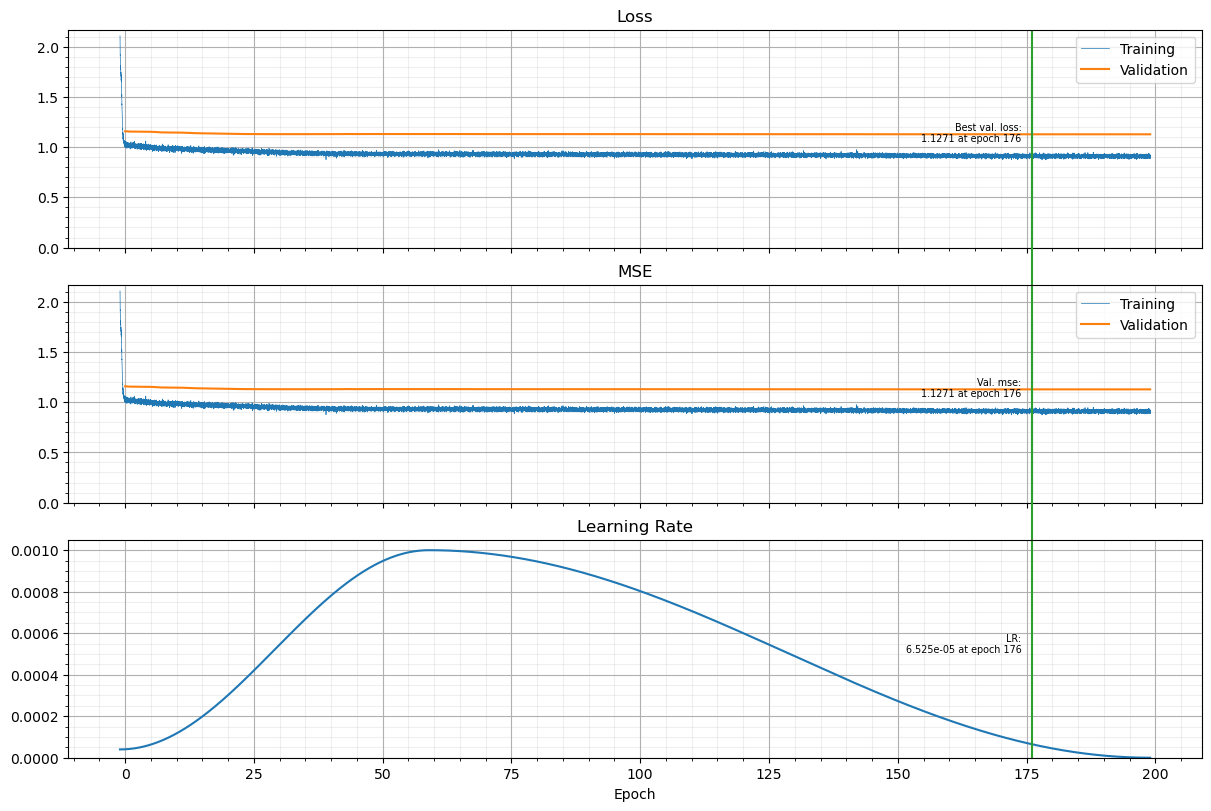

In [11]:
# Model Initialization
model = AutoEncoder(inp_dim=sc_mix_d["train"].shape[1], **autoencoder_kwargs)
model = model.to(device)
model.apply(initialize_weights)
print(model)


# Using an Adam Optimizer with lr = 0.1

results_history_out = train(
    model,
    model_folder,
    dataloader_source_train,
    dataloader_source_val,
    epochs=INITIAL_TRAIN_EPOCHS,
    **adamw_kwargs
)

best_checkpoint = torch.load(os.path.join(model_folder, f"final_model.pth"))
best_epoch = best_checkpoint["epoch"]

train_history_running = results_history_out["train"]["running"]
val_history = results_history_out["val"]["avg"]
plot_results(train_history_running, val_history, best_epoch, save_folder=model_folder)

In [12]:
model = best_checkpoint["model"]
model.to(device)
model.eval()
with torch.no_grad():
    avg_results_train, running_results_train = run_epoch(dataloader_source_train, model)
    avg_results_val, running_results_val = run_epoch(dataloader_source_val, model)
    avg_results_test, running_results_test = run_epoch(dataloader_source_test, model)


In [13]:
(np.std(sc_mix_d["train"], axis=0) ** 2).mean()

0.9909659863945621

In [14]:
print(
    pd.concat(
        [
            pd.Series(avg_results_train).to_frame().T,
            pd.Series(avg_results_val).to_frame().T,
            pd.Series(avg_results_test).to_frame().T,
        ],
        keys=["train", "val", "test"],
    )
)


             loss       mse        bs
train 0  0.902217  0.902217  511.4368
val   0  1.127092  1.127092  506.9120
test  0  1.073295  1.073295  506.9120
